In [1]:
import pandas as pd
import requests
import json
import io
import zipfile
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
# remove Umlauts in Ländername Österreich etc for filenames
from unidecode import unidecode

In [2]:
pd.__version__

'2.2.3'

In [3]:
#plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['axes.titleweight'] = "bold"
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['svg.fonttype'] = 'none' # 'none' | 'path'
plt.rcParams['font.family'] = 'sans-serif' # 'Fira Sans' | 'sans-serif'

In [9]:
# use API token as credentials
TOKEN = "1b3YOURc6TOKEN43cHERE5e6d032"

# Set base path for API calls
BASE_URL = 'https://www-genesis.destatis.de/genesisWS/rest/2020/'

In [6]:
# to future-proof this example, it now uses POST throughout
# user credentials are sent in the POST-Header
headers = {
    'Content-Type': 'application/x-www-form-urlencoded',
    'username': TOKEN,
    'password': ""
    }

# prefered language for all requests
langPref = "de"

### Check login credentials

In [7]:
hello = requests.post(BASE_URL + 'helloworld/logincheck', 
    headers = headers,
    data = {
    'language': langPref
})
hello.json()["Status"]

'Sie wurden erfolgreich an- und abgemeldet! Bei mehr als 3 parallelen Requests wurden länger als 15 Minuten laufende Requests beendet.'

## Load table

In [8]:
response = requests.post(BASE_URL + 'data/tablefile',
    headers = headers,
    data = {
    'name': '43312-0002',
    # methodology change in 2013
    'startyear': 2013,
    'area': 'all',
    'compress': 'true',
    'format': 'ffcsv',
    'language': langPref
})
# check if returns text, binary or nothing at all
# print(response.text[0:120])

### Read returned zip-file directly from memory

In [10]:
filebytes = io.BytesIO(response.content)
zipInput = zipfile.ZipFile(filebytes)
csvInput = zipInput.open(zipInput.namelist()[0])

In [11]:
df = pd.read_csv(csvInput, delimiter=';', decimal=",", na_values=["...",".","-","/","x"])

### Alternative: Write to disk

In [33]:
with open("tmp/table.zip", "wb") as f:
    f.write(response.content)

In [34]:
df = pd.read_csv("tmp/table.zip", delimiter=';', decimal=",", na_values=["...",".","-","/","x"])

### Prepare data

In [12]:
# rename column names starting with a digit for easier querying
df.columns = ["_"+colname if colname[0].isdigit() else colname for colname in df.columns]

In [13]:
df.tail(3)

,statistics_code,statistics_label,time_code,time_label,time,_1_variable_code,_1_variable_label,_1_variable_attribute_code,_1_variable_attribute_label,_2_variable_code,...,_2_variable_attribute_code,_2_variable_attribute_label,_3_variable_code,_3_variable_label,_3_variable_attribute_code,_3_variable_attribute_label,value,value_unit,value_variable_code,value_variable_label
4129,43312,Erh. ü.Stromein- u.-ausspeisung bei Netzbetrei...,JAHR,Jahr,2015,MONAT,Monate,MONAT03,März,DINSG,...,DG,Deutschland,LAEN01,Länder,ST148,Niederlande,-2291477.0,MWh,SDO001,Austauschsaldo
4130,43312,Erh. ü.Stromein- u.-ausspeisung bei Netzbetrei...,JAHR,Jahr,2015,MONAT,Monate,MONAT03,März,DINSG,...,DG,Deutschland,LAEN01,Länder,ST148,Niederlande,1385.0,MWh,EKT102,Einfuhr von Elektrizität
4131,43312,Erh. ü.Stromein- u.-ausspeisung bei Netzbetrei...,JAHR,Jahr,2015,MONAT,Monate,MONAT03,März,DINSG,...,DG,Deutschland,LAEN01,Länder,ST148,Niederlande,2292862.0,MWh,EKT202,Ausfuhr von Elektrizität


In [14]:
df["myTime"] = pd.to_datetime(pd.DataFrame({'year':df["time"], 'month':df["_1_variable_attribute_code"].str[-2:], 'day':15}))

In [15]:
dfMyCols = df[["myTime","_3_variable_attribute_label", 
               "value", "value_variable_label"]]

In [16]:
dfMyCols.head(5)

,myTime,_3_variable_attribute_label,value,value_variable_label
0,2024-04-15,Insgesamt,2458255.0,Austauschsaldo
1,2024-04-15,Insgesamt,6081271.0,Einfuhr von Elektrizität
2,2024-04-15,Insgesamt,3623016.0,Ausfuhr von Elektrizität
3,2013-12-15,Dänemark,NaN,Austauschsaldo
4,2013-12-15,Dänemark,NaN,Einfuhr von Elektrizität


In [17]:
lastObservation = dfMyCols.loc[(dfMyCols["_3_variable_attribute_label"]=="Insgesamt") & \
                (dfMyCols["value"].notna())]["myTime"].max()

In [18]:
lastObservation

Timestamp('2024-08-15 00:00:00')

In [19]:
dfPivot = dfMyCols.pivot(index=["_3_variable_attribute_label","myTime"], 
                         columns="value_variable_label", values="value")#.dropna()

In [20]:
myStaat='Belgien und Luxemburg'
startyear=2017
dfPivot.query("myTime>=@startyear & _3_variable_attribute_label==@myStaat").reset_index()

value_variable_label,_3_variable_attribute_label,myTime,Ausfuhr von Elektrizität,Austauschsaldo,Einfuhr von Elektrizität
0,Belgien und Luxemburg,2017-01-15,411631.0,-411631.0,NaN
1,Belgien und Luxemburg,2017-02-15,358143.0,-358143.0,NaN
2,Belgien und Luxemburg,2017-03-15,375952.0,-375952.0,NaN
3,Belgien und Luxemburg,2017-04-15,335828.0,-335828.0,NaN
4,Belgien und Luxemburg,2017-05-15,352402.0,-352402.0,NaN
...,...,...,...,...,...
87,Belgien und Luxemburg,2024-04-15,384223.0,-53599.0,330624.0
88,Belgien und Luxemburg,2024-05-15,426018.0,104357.0,530375.0
89,Belgien und Luxemburg,2024-06-15,396403.0,162686.0,559089.0
90,Belgien und Luxemburg,2024-07-15,437568.0,95121.0,532689.0


In [40]:
def drawChart(myStaat):
    
    startyear=2013
    
    mydf = dfPivot.query("myTime>=@startyear & _3_variable_attribute_label==@myStaat").reset_index()
   
    # Create figure and plot space
    fig, ax = plt.subplots(figsize=(16, 4))

    # Add x-axis and y-axis
    ax.bar(mydf['myTime'], mydf['Austauschsaldo']/1E6, width=31, color='#C9C4A8', label="Saldo")

    ax.plot(mydf['myTime'], mydf['Einfuhr von Elektrizität']/1E6, linewidth=3, label="Import", color="#e71111")
    ax.plot(mydf['myTime'], mydf['Ausfuhr von Elektrizität']/1E6, linewidth=3, label="Export", color="#447EC6")

    # Set title and labels for axes
    ax.set_title(myStaat, pad=10, color="#2C3E35")
    ax.set_ylabel(ylabel='Elektrizität (TWh)', labelpad=10, size=12, color="#2C3E35")

    ax.set_xlim(pd.to_datetime(str(startyear)+"-01-01"), lastObservation + pd.DateOffset(months=2))
        
    ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%m'))
    
    ax.tick_params(axis='x', which='major', length=20, labelsize=11)
    ax.tick_params(axis='x', which='minor', length= 3, labelsize=8)
    
    ax.yaxis.set_major_locator(ticker.FixedLocator([0]))
    ax.yaxis.set_minor_locator(ticker.MaxNLocator())
    ax.yaxis.set_minor_formatter(ticker.ScalarFormatter())
    ax.tick_params(axis='y', which='major', length=3, labelsize=10)
    ax.tick_params(axis='y', which='minor', length=3, labelsize=10)
    
    ax.grid(which='major', axis='x', color='#fff', linewidth=0.5)
    ax.grid(which='major', axis='y', color='#333', linewidth=0.75)
    ax.grid(which='minor', axis='y', color='#fff', linewidth=0.5)

    ax.legend(loc="upper left", bbox_to_anchor=(1.01, .9), facecolor="none", edgecolor="none")
    
    plt.box(False)
    plt.tight_layout()
    
    #my_land = unidecode(myStaat).replace(" ", "_")
    #plt.savefig('img/'+my_land+'_Strom_ImportExport.svg', transparent=True)
    
    plt.show()

In [41]:
staaten = dfPivot.index.get_level_values(0).unique().to_list()
staaten

['Belgien und Luxemburg',
 'Dänemark',
 'Frankreich',
 'Insgesamt',
 'Niederlande',
 'Polen',
 'Schweiz',
 'Sonstige Länder',
 'Tschechien',
 'Österreich']

In [42]:
nachbarn = ['Insgesamt', 'Frankreich', 'Polen', 'Niederlande', 'Österreich', 'Tschechien', 'Belgien und Luxemburg', 'Sonstige Länder']

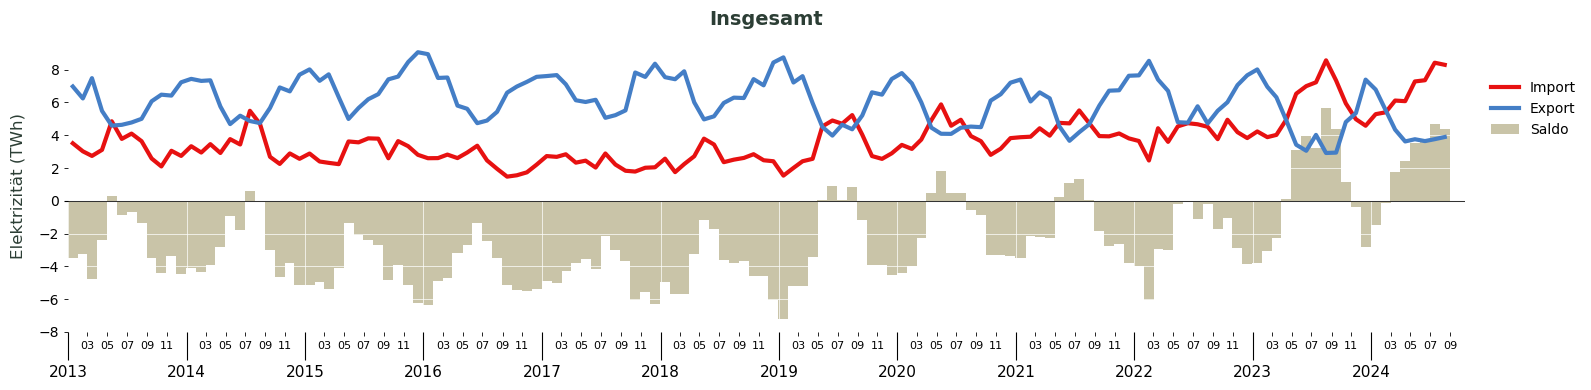

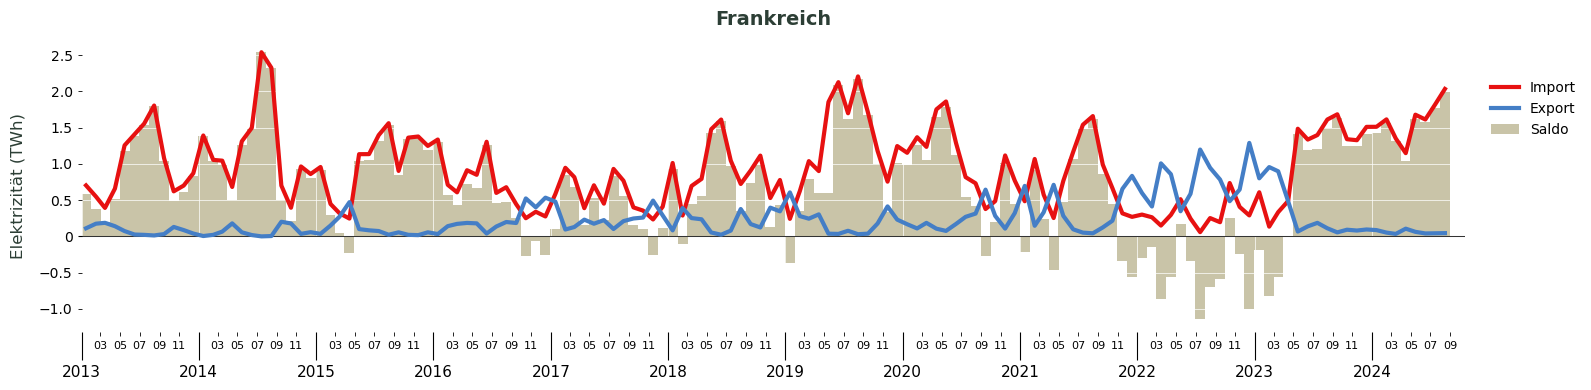

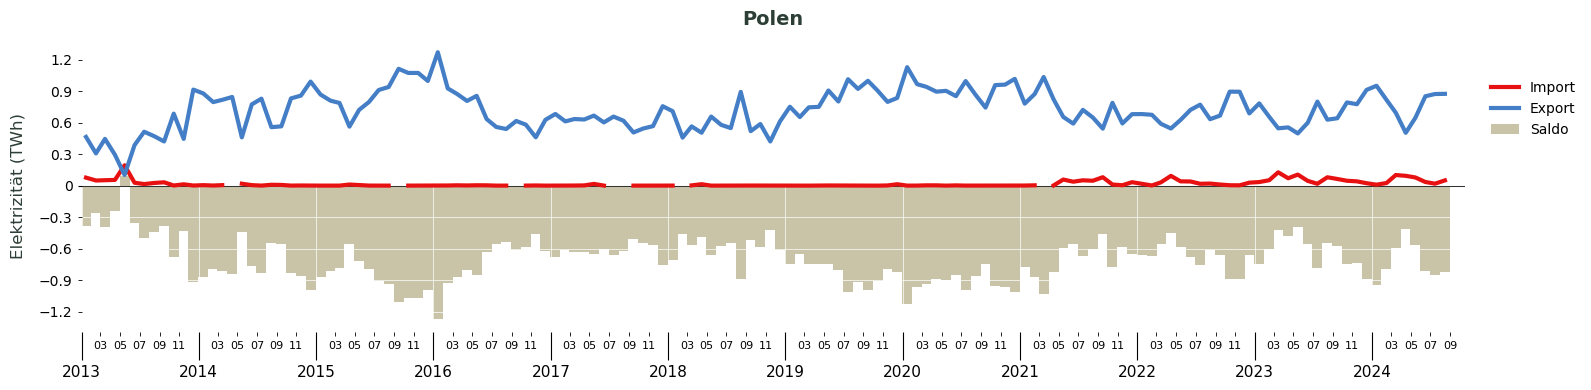

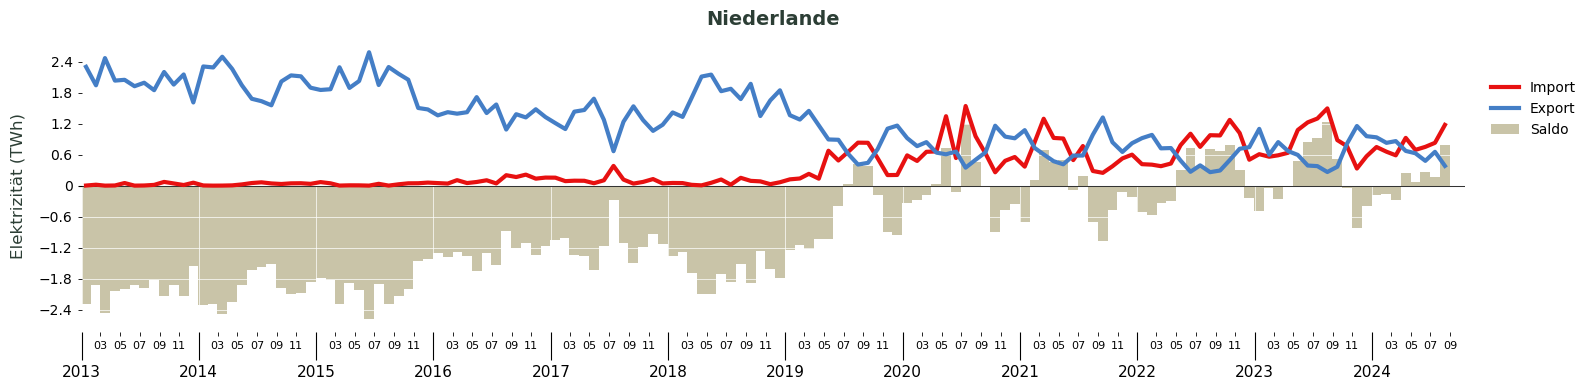

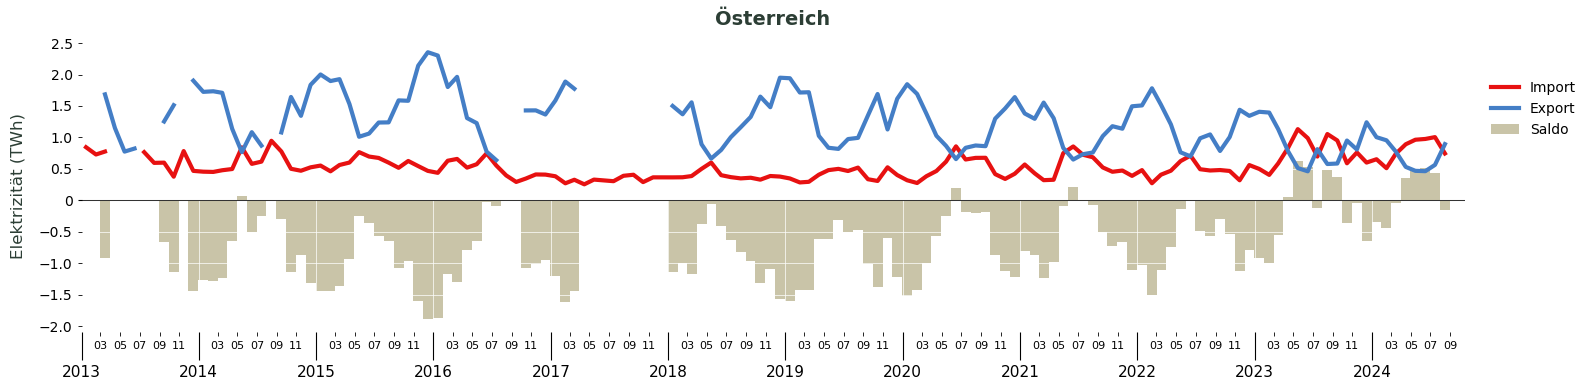

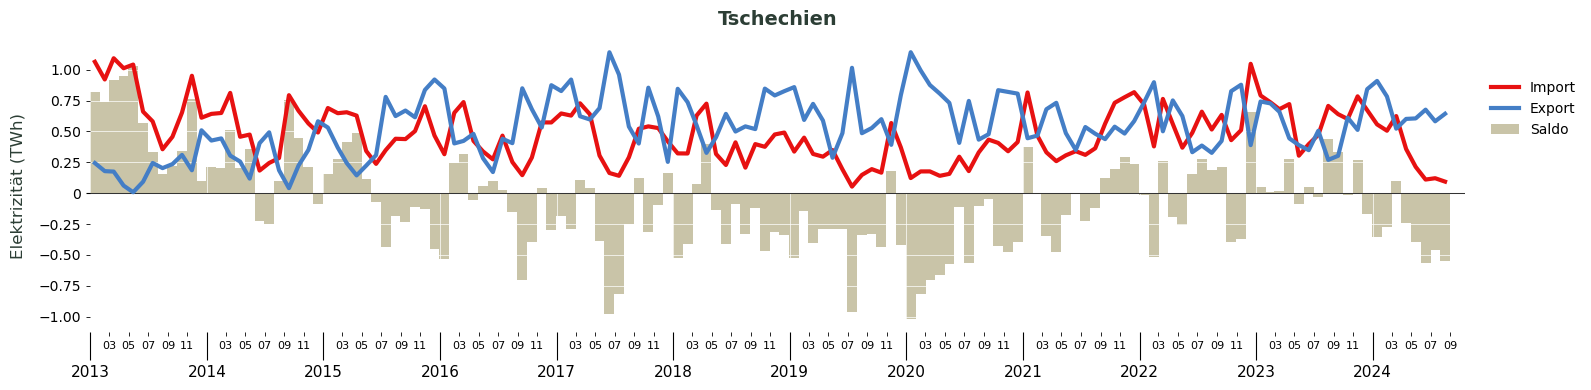

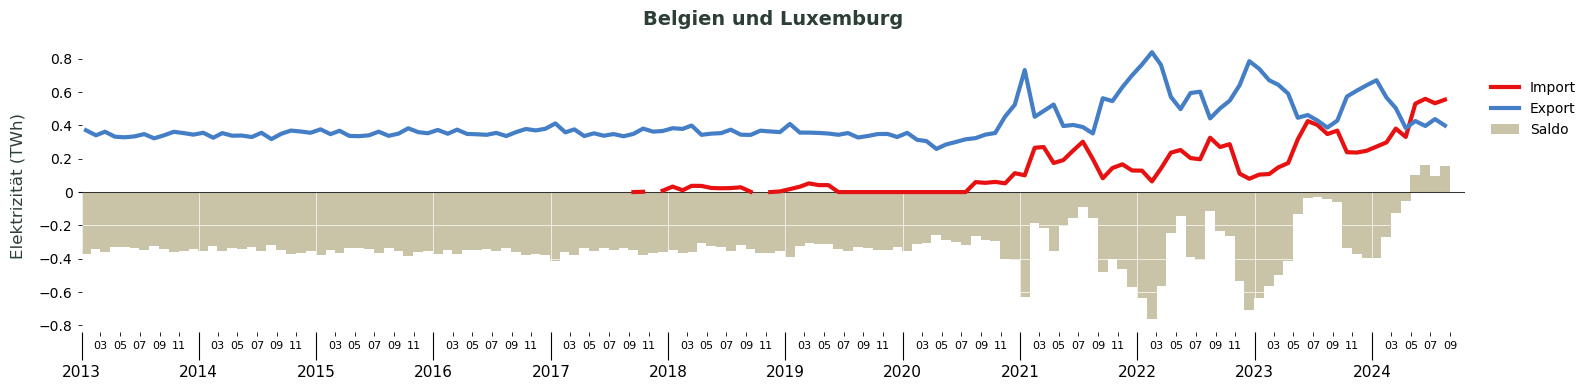

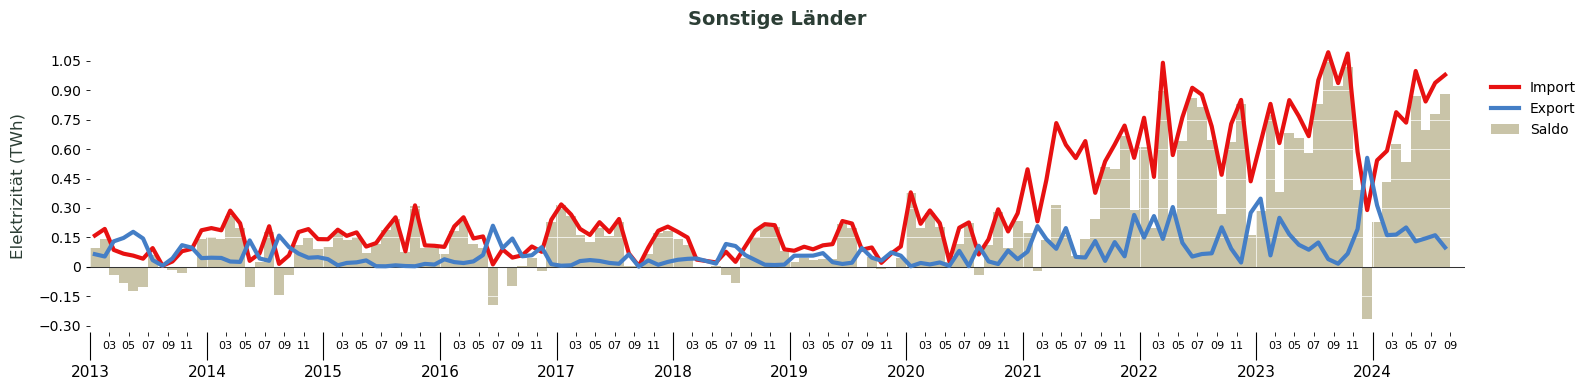

In [43]:
for nachbar in nachbarn:
    drawChart(nachbar)